In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import surprise
import time
from sklearn.model_selection import train_test_split
from surprise import KNNWithMeans
from surprise import SVD
from surprise import Reader,Dataset
from surprise import accuracy
from apyori import apriori

Context

Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different
suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive
data sets and produces high-quality recommendations in real-time.


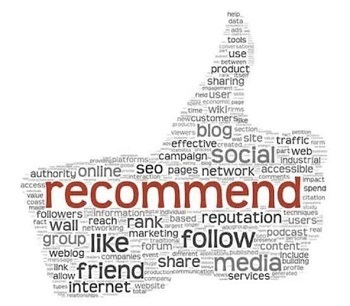


# 1.Read and explore the given dataset

In [2]:
elec_df = pd.read_csv('ratings_Electronics.csv')
elec_df.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


# Rename column/add headers

In [3]:
elec_df.rename(columns={'AKM1MP6P0OYPR':'userId','0132793040':'productId','5.0':'Rating', '1365811200':'Timestamp'}, inplace=True)
elec_df.head()

,userId,productId,Rating,Timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600



# Plot histograms

C:\Users\Surya-Rekha\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Surya-Rekha\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


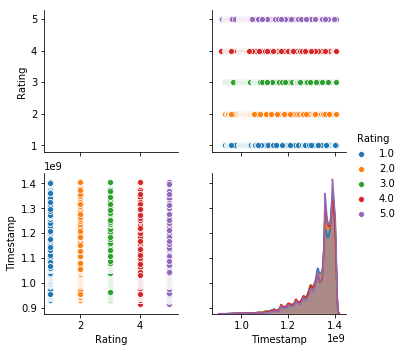

In [4]:
sns.pairplot(elec_df,hue='Rating')

Text(0, 0.5, 'Frequency')

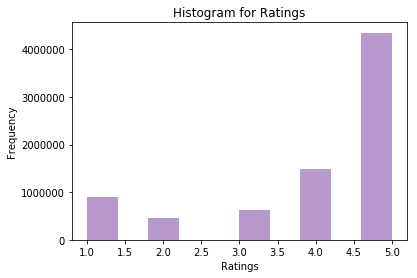

In [5]:
sns.distplot(elec_df["Rating"],bins=10,color='indigo',label="Rating",kde=False)
plt.title("Histogram for Ratings")
plt.xlabel("Ratings")
plt.ylabel("Frequency")

Insight: Many users have given ratings in range of 4.5 and 5, then 4, 1,3

Text(0, 0.5, 'Frequency')

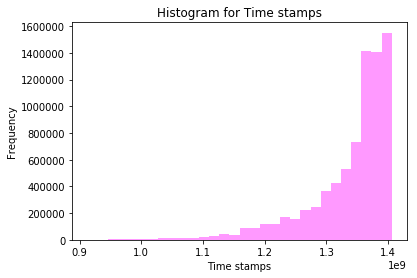

In [6]:
sns.distplot(elec_df["Timestamp"],bins=30,color='magenta',label="Time stamp",kde=False)
plt.title("Histogram for Time stamps")
plt.xlabel("Time stamps")
plt.ylabel("Frequency")

Descriptive Statistics for data characteristics

In [7]:
elec_df.describe().T


,count,mean,std,min,25%,50%,75%,max
Rating,7824481.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
Timestamp,7824481.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


In [8]:
elec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
userId       object
productId    object
Rating       float64
Timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [9]:
print('Shape of dataframe = {}'.format(elec_df.shape))

Shape of dataframe = (7824481, 4)


# 2. Take a subset of the dataset to make it less sparse/ denser (keep the users only who has given 50 or  more number of ratings)

In [10]:
elec_df.head()

,userId,productId,Rating,Timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [11]:
elec_df.groupby(["userId", "Rating"])["Rating"].count()

userId                 Rating
A00000262KYZUE4J55XGL  5.0        1
A000063614T1OE0BUSKUT  5.0        2
A00009182QVLSWIGHLS1B  5.0        1
A00009661LC9LQPGKJ24G  5.0        1
A00010809P09NUU6ZP6H   5.0        1
A00014061C2IZNE0YEILY  4.0        1
A000145014WOTZJ5NSKOR  5.0        1
A00015222LZ55IJSVL5IX  1.0        1
A00015228CUPGPF957DS   1.0        1
A0001528BGUBOEVR6T5U   3.0        1
                       5.0        3
A00018041RRVMCICCAP79  5.0        2
A000186437REL8X2RW8UW  4.0        1
A000187635I595IAVSQLH  5.0        2
A00019466UY2KR1IPXQN   4.0        1
A0002012T7HVDB2EF4RH   4.0        1
A0002032ZFQKDVHYKGWR   5.0        1
A0002550196XWX0PEOZND  3.0        1
A00027081JC8NE8X6TD5   5.0        1
A00027561NC7JTXEP3EOD  1.0        1
A00028781NF0U7YEN9U19  5.0        1
A00029263J863WSR0TDRS  4.0        1
A000294826HEMAY5L3K1H  5.0        1
A00029825UMZ6N0ETLHY   5.0        1
A00033481VZEEGYXEN32T  1.0        1
                       5.0        2
A00037441I8XOQJSUWCAG  5.0        

Insight: 

elec_sub= elec_df[elec_df.Rating.groupby(elec_df.userId).transform('count') >= 50] -->> Sparse dataframe/matrix with users who has given 50 or more ratings is throwing memory error at computing pearson baseline similarity matrix of fitting "KNNWithMeans" model step, hence going on with users has given 100 or more ratings.

In [12]:
elec_sub= elec_df[elec_df.Rating.groupby(elec_df.userId).transform('count') >= 250]
elec_sub

,userId,productId,Rating,Timestamp
2161,A5JLAU2ARJ0BO,1400532655,1.0,1291334400
3382,A3PD8JD9L4WEII,1400699169,5.0,1372204800
5194,A36K2N527TXXJN,9800359788,5.0,1367280000
5931,ADLVFFE4VBT8,9981719005,3.0,1238716800
7747,A680RUE1FDO8B,B000001OMI,5.0,1227744000
8731,A6FIAB28IS79,B00000J05A,3.0,985564800
10393,AWPODHOB4GFWL,B00000J1QS,4.0,1241740800
11017,A6FIAB28IS79,B00000J1UQ,5.0,1251763200
11035,A231WM2Z2JL0U3,B00000J1US,5.0,1010880000
12679,A6FIAB28IS79,B00000J4CY,3.0,1199404800


Total 7484 users gave 250 or more ratings.

# 3. Split the data randomly into train and test dataset

Splitting dataset using sklearn is as follows.
trainset, testset = train_test_split(ratings_df, test_size=0.3)

But I will do train_test_split using surprise package. 
To do this in surprise library we should load data first into it's own data frame, using 'load_from_df'
then can be splitted into train and test sets used in item-to-item colloborative filtering approach. 

# 4. Build Popularity Recommendation Model

In [13]:
elec_sub.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B002NU5O8I    5.0
B003QRX4PC    5.0
B003ZK5NZY    5.0
B003ZG9T62    5.0
B003ZBZ64Q    5.0
Name: Rating, dtype: float64

In [14]:
pop_ratings_mean_count = pd.DataFrame(elec_sub.groupby('productId')['Rating'].mean())
pop_ratings_mean_count['rating_counts'] = pd.DataFrame(elec_sub.groupby('productId')['Rating'].count())

In [15]:
pop_ratings_mean_count.head(10)

,Rating,rating_counts
productId,,
1400532655,1.0,1
1400699169,5.0,1
9800359788,5.0,1
9981719005,3.0,1
B000001OMI,5.0,1
B00000J05A,3.0,1
B00000J1QS,4.0,1
B00000J1UQ,5.0,1
B00000J1US,5.0,1


# 5.Build Collaborative Filtering model

In [16]:
# to load dataset from pandas df, we need `load_fromm_df` method in surprise lib
ratings_dict = {'userId': list(elec_sub.userId),
                'productId': list(elec_sub.productId),
                'Rating': list(elec_sub.Rating)}

In [17]:
df = pd.DataFrame(ratings_dict)

In [18]:
df.head()

,userId,productId,Rating
0,A5JLAU2ARJ0BO,1400532655,1.0
1,A3PD8JD9L4WEII,1400699169,5.0
2,A36K2N527TXXJN,9800359788,5.0
3,ADLVFFE4VBT8,9981719005,3.0
4,A680RUE1FDO8B,B000001OMI,5.0


In [19]:
# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(1.0, 5.0))

In [20]:
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userId', 'productId', 'Rating']], reader)

Splitting Datasets into train and test 

In [21]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.3)

# Collaborative filtering

Item-Item collaborative filtering using KNN

In [30]:
# Creating KNN model
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})

In [31]:
# Fitting model with trainset
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [32]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [33]:
test_pred

[Prediction(uid='A2XRMQA6PJ5ZJ8', iid='B0012NDQD2', r_ui=1.0, est=4.311951126384116, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A6FIAB28IS79', iid='B0074703CM', r_ui=5.0, est=4.311951126384116, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A680RUE1FDO8B', iid='B000MWNJPE', r_ui=5.0, est=4.311951126384116, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A22CW0ZHY3NJH8', iid='B00BUACE8K', r_ui=5.0, est=4.070911694707606, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid='A25C2M3QF9G7OQ', iid='B001FWBUUG', r_ui=5.0, est=4.311951126384116, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2NOW4U7W3F7RI', iid='B009K184TO', r_ui=5.0, est=4.311951126384116, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A23GFTVIETX7DS', iid='B007MDQIH2', r_ui=3.0, 

SVD (Singular Valued Decomposition)

In [34]:
svd_alg = SVD()

In [35]:
svd_alg.fit(trainset)

In [36]:
svd_testpred =svd_alg.test(testset,verbose=False)

In [37]:
svd_testpred

[Prediction(uid='A2XRMQA6PJ5ZJ8', iid='B0012NDQD2', r_ui=1.0, est=4.59521131385829, details={'was_impossible': False}),
 Prediction(uid='A6FIAB28IS79', iid='B0074703CM', r_ui=5.0, est=4.155201546972139, details={'was_impossible': False}),
 Prediction(uid='A680RUE1FDO8B', iid='B000MWNJPE', r_ui=5.0, est=4.345330572406153, details={'was_impossible': False}),
 Prediction(uid='A22CW0ZHY3NJH8', iid='B00BUACE8K', r_ui=5.0, est=4.262628991044934, details={'was_impossible': False}),
 Prediction(uid='A25C2M3QF9G7OQ', iid='B001FWBUUG', r_ui=5.0, est=4.600226042110198, details={'was_impossible': False}),
 Prediction(uid='A2NOW4U7W3F7RI', iid='B009K184TO', r_ui=5.0, est=4.774401607654975, details={'was_impossible': False}),
 Prediction(uid='A23GFTVIETX7DS', iid='B007MDQIH2', r_ui=3.0, est=4.386676315811341, details={'was_impossible': False}),
 Prediction(uid='A1ODOGXEYECQQ8', iid='B006421IRW', r_ui=5.0, est=4.24997153110633, details={'was_impossible': False}),
 Prediction(uid='ARBKYIVNYWK3C', iid=

# 6.Evaluate both the models. ( Once the model is trained on  the training data, it can be used to compute the error  (RMSE) on predictions made on the test data.) 

RMSE for SVD

In [38]:
# get RMSE
print("SVD Model : Test Set")
accuracy.rmse(svd_testpred, verbose=True)

SVD Model : Test Set
RMSE: 0.8780


0.8779801077352093

RMSE for KNN

In [39]:
# get RMSE
print("KNN Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

KNN Model : Test Set
RMSE: 0.9412


0.9412471948921131

# 7.Get top - K ( K = 5) recommendations. Since our goal is to  recommend new products for each user based on his/her  habits, we will recommend 5 new products.

Using SVD model

In [40]:
svd_testpred[:5]

[Prediction(uid='A2XRMQA6PJ5ZJ8', iid='B0012NDQD2', r_ui=1.0, est=4.59521131385829, details={'was_impossible': False}),
 Prediction(uid='A6FIAB28IS79', iid='B0074703CM', r_ui=5.0, est=4.155201546972139, details={'was_impossible': False}),
 Prediction(uid='A680RUE1FDO8B', iid='B000MWNJPE', r_ui=5.0, est=4.345330572406153, details={'was_impossible': False}),
 Prediction(uid='A22CW0ZHY3NJH8', iid='B00BUACE8K', r_ui=5.0, est=4.262628991044934, details={'was_impossible': False}),
 Prediction(uid='A25C2M3QF9G7OQ', iid='B001FWBUUG', r_ui=5.0, est=4.600226042110198, details={'was_impossible': False})]

Using KNN model

In [41]:
## Calculating KNNWithMeans for K=5
algo_k5 = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})

In [42]:
## Train algorithm on trainset
algo_k5.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [43]:
## Test algorithm against testset
test_pred5 = algo_k5.test(testset, verbose=False)

In [44]:
## Recommending 5 new products
test_pred5[:5]

[Prediction(uid='A2XRMQA6PJ5ZJ8', iid='B0012NDQD2', r_ui=1.0, est=4.311951126384116, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A6FIAB28IS79', iid='B0074703CM', r_ui=5.0, est=4.311951126384116, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A680RUE1FDO8B', iid='B000MWNJPE', r_ui=5.0, est=4.311951126384116, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A22CW0ZHY3NJH8', iid='B00BUACE8K', r_ui=5.0, est=4.070911694707606, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid='A25C2M3QF9G7OQ', iid='B001FWBUUG', r_ui=5.0, est=4.311951126384116, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'})]

In [45]:
# get RMSE
print("Item-based Model for 5 recommendations : Test Set")
accuracy.rmse(test_pred5, verbose=True)

Item-based Model for 5 recommendations : Test Set
RMSE: 0.9413


0.9413057615493157

Using Popularity based model

In [46]:
pop_ratings_mean_count[:5]

,Rating,rating_counts
productId,,
1400532655,1.0,1
1400699169,5.0,1
9800359788,5.0,1
9981719005,3.0,1
B000001OMI,5.0,1


# 8.Summary of Insights

1.Personalization is a key factor for any recommendation systems of based, user-user or item-item.

2.Popularity based recommendation system doesn’t give any personalizations as shown above which only gives the same list of recommended items/products to all users at a shot based up on ratings.

Hence Popularity Based Recommendation System is not good or suggestable for "Amazon" review dataset.

3.In terms of RMSE metric, KNN (=0.9412) is performing better than SVD (=0.8780).

4.SVD and KNN are recommending same items to the users 'A22CW0ZHY3NJH8', 'A36K2N527TXXJN', 'A5JLAU2ARJ0BO', 'A23GFTVIETX7DS', 'A12DQZKRKTNF5E'.

5.In KMeans collaborative filtering we can see cold start problem, where as in SVD we doesn't have dealt with any cold start problem.

(Cold Start problem: 'was_impossible': True, 'reason': 'User and/or item is unkown.')